# Western Gap current 270°

In [1]:
#%matplotlib widget
import numpy as np
from matplotlib import ticker
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#import scipy
import pandas as pd

import scipy as scipy
from scipy import signal
from scipy.fftpack import fft, fftshift
import math

import netCDF4
import os
from chardet import detect
import chardet
import csv

In [2]:
def Ekman_u(z,a,U):
    
    u = U*(1-np.exp(-a*z)*np.cos(a*z))
    
    return u
    
def Ekman_v(z,a,U):
    
    v = U*np.exp(-a*z)*np.sin(a*z)
    
    return v


def get_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = detect(raw_data)
        return result['encoding']
    
    
def convert_to_utf8(file_path):
    # Открываем файл в бинарном режиме для определения кодировки
    with open(file_path, 'rb') as file:
        content = file.read()
    
    # Определяем кодировку файла
    detected_encoding = chardet.detect(content)['encoding']
    
    if detected_encoding.lower() != 'utf-8':
        print(f'Файл имеет кодировку {detected_encoding}. Перекодируем в UTF-8.')
        
        # Чтение файла с правильной кодировкой
        with open(file_path, 'r', encoding=detected_encoding) as file:
            text = file.read()
            
        # Запись файла в UTF-8
        with open(file_path, 'w', encoding='utf-8') as file:
            file.write(text)
            
        print('Перекодирование завершено!')
    else:
        print('Файл уже в кодировке UTF-8.')  


def file_base_name(file_name): # функция определяет название файла
    if '.' in file_name:
        separator_index = file_name.index('.')
        base_name = file_name[:separator_index]
        return base_name
    #else:
        #return file_name


def angle(U,V):
    U, V = np.array(U), np.array(V)
    a = np.arctan2(U,V)
    a = np.rad2deg(a)
    a[a < 0] += 360
    a = np.around(a, decimals = 0)
    a[a==360] = 0
    return a

def turn(U,V,theta):
    U, V = np.array(U), np.array(V)
    deg = 360-theta
    if deg>90:
        deg = -theta
    deg = np.deg2rad(deg)
    turn = np.array([[np.cos(deg), np.sin(deg)],
                    [-np.sin(deg), np.cos(deg)]])
    vector = np.array([U,V])
    new_vector = turn @ vector
    U_new = new_vector[0]
    V_new = new_vector[1]

    return U_new, V_new


def nan_interpolation(data):
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    data[bad_indexes] = interpolated
    return data

def _bindata(series, delta, method):  
    start = np.ceil(series.index[0])  
    stop = np.floor(series.index[-1]+1.0)  
    new_index = np.arange(start, stop, delta)  
    binned = pd.cut(series.index, bins=new_index)  
    if method == "average":  
        new_series = series.groupby(binned).mean()  
        new_series.index = new_index[:-1] + delta / 2  
    elif method == "interpolate":  
        data = np.interp(new_index, series.index, series)  
        return pd.Series(data, index=new_index, name=series.name)  
    return new_series  

     
def bindata(df, delta, method):  
#    """  
#    Bin average the index (usually pressure) to a given interval (default  
#    delta = 1).  
    
#    """  
    if isinstance(df, pd.Series):  
        new_df = _bindata(df, delta=delta, method=method)  
    else:  
        new_df = df.apply(_bindata, delta=delta, method=method)  
    return new_df  



def filter_cos(a,b,length):
    c = []
    d = []
    for i in range(len(b)):
        sum_values = 0
        sum_weights = 0
        for j in range(len(a)):
                if ((a[i] - length / 2) < a[j]) and (a[j] < (a[i] + length / 2)):
                    sum_values += (1 + math.cos(2*math.pi*abs(a[i] - a[j])/(length))) * b[j]
                    sum_weights += 1 + math.cos(2*math.pi*abs(a[i] - a[j])/(length))           
        d.append(sum_values/sum_weights)
        c.append(a[i])
    return(d)


In [3]:
dir = 'lad/'
file = []
for filename in sorted(os.listdir(dir)):
    #print(filename)
    file.append(filename)
file = np.array(file[1:])
file

array(['2467.lad', '2468.lad', '2469.lad', '2470.lad', '2471.lad',
       '2472.lad', '2480.lad', '2481.lad', '2482.lad', '2483.lad',
       '2485.lad', '2486.lad', '2487.lad', '2509.lad', '2510.lad',
       '2511.lad', '2512.lad', '2513.lad', '2513_1.lad', '2513_5.lad',
       '2515.lad', '2516.lad', '2517.lad', '2538.lad'], dtype='<U10')

In [4]:
Lat = []
Log = []
St = []
max_depth = []
for i in range(file.size):
    convert_to_utf8(dir + file[i])
    with open(dir + file[i]) as f:
        lat, lon = f.readlines()[3:5]
    L = lat.split('=')[1][:-2]
    R = L.split()
    T = R[0].split()
    Y = T[0].split('°S')
    lat_deg = float(Y[0])
    lat_min = (float(R[1]))/60 
    latitude = lat_deg + lat_min
    Lat.append(latitude)
    Lg = lon.split('=')[1][:-2]
    Q = Lg.split()
    W = Q[0].split()
    E = W[0].split('°W')
    lon_deg = float(E[0])
    lon_min = (float(Q[1]))/60
    longitude = lon_deg + lon_min
    longitude = - longitude
    Log.append(longitude)
    data = pd.read_csv(dir + file[i], sep="\s+", names=['z','u', 'v', 'error'],skiprows=7)
    station = file_base_name(file[i])
    St.append(station)
    df = data.copy()
    floor_i = df['z'].index[-1]
    Max_d = df['z'][floor_i]
    max_depth.append(Max_d)

Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.
Файл уже в кодировке UTF-8.


In [5]:
base = pd.DataFrame([Log,Lat,St,max_depth])#, columns = ['longitude', 'latitude','station','stationMaxDepth'])
base = base.T
names = {'longitude:','latitude:','station:','stationMaxDepth:'}
#base.append(names, ignore_index = True)
base = base.rename({0:'longitude',1:'latitude',2:'station',3:'stationMaxDepth'},axis=1)
base.to_csv('Romanche FZ base.txt', sep='\t', index= False)
base

,longitude,latitude,station,stationMaxDepth
0,-22.34219,0.99039,2467,4912.0
1,-22.1754,0.97458,2468,5568.0
2,-22.17516,0.91734,2469,4904.0
3,-22.17536,0.86624,2470,5240.0
4,-22.17516,0.81667,2471,4320.0
5,-22.45696,1.10792,2472,4608.0
6,-22.55776,1.049003,2480,4424.0
7,-22.45812,1.141353,2481,4664.0
8,-22.45836,1.09928,2482,4560.0
9,-22.427463,0.82354,2483,4368.0


In [6]:
# bottom = netCDF4.Dataset('strait.nc', mode="r")
# #print(nc.variables.keys())

In [7]:
# bottom_lon = np.arange(bottom['x_range'][0], bottom['x_range'][1], bottom['spacing'][0])
# bottom_lat = np.arange(bottom['y_range'][0], bottom['y_range'][1], bottom['spacing'][1])
# z = bottom['z'][:].data.reshape((len(bottom_lat), len(bottom_lon)))
# np.where((bottom_lat > 65.9) & (bottom_lat < 66.1))

# bottom_lat[116]
# #z[0,:].size # 0 - lat index
# #bottom_lat[13]

In [8]:
# from IPython import display
# display.Image('strait_stationMap.jpg')

## Processing - cut-off 300m, max speed self-evaluated ~ 70m

In [9]:
dir = 'SE/'
file = []
for filename in sorted(os.listdir(dir)):
    #print(filename)
    file.append(filename)
file = np.array(file[:])
file = file[1:]
file

array(['2472.lad', '2482.lad', '2487.lad', '2509.lad', '2511.lad',
       '2512.lad'], dtype='<U9')

In [10]:
Ndir = 'processed/'
files = os.listdir(dir)
for k in files:
    file_path = os.path.join(dir,k)
    if file_path.endswith('.txt'):
        os.remove(file_path)

In [11]:
Ndir = 'raw/'
files = os.listdir(Ndir)
for k in files:
    file_path = os.path.join(Ndir,k)
    if os.path.isfile(file_path):
        os.remove(file_path)

In [12]:
#St = []
max_speed = []
#max_depth = []

for j in range(file.size):
    data = pd.read_csv(dir + file[j], sep="\s+", names=['z','u', 'v', 'error'],skiprows=7)
    station = file_base_name(file[j])
    #St.append(station)
    df = data.copy()
    floor_i = df['z'].index[-1]
    Max_d = df['z'][floor_i]
    #max_depth.append(Max_d)
    df['dist'] = (df['z'][floor_i]+5) - df['z']
    df = df.loc[df['dist']<300, ['z','u','v','dist']]
    df['mod'] = np.sqrt(df['u']**2 + df['v']**2)
    df['dir'] = angle(df['u'],df['v'])
    df = df.sort_values('dist')
    df = df.reset_index()
    df = df.drop(columns=['index'])
    df.to_csv('raw/'+station+'.txt', sep='\t', index=False)
    vel_i = 6#df['mod'].idxmax()#5#df['dist'].index[5]
    df['u_'], df['v_'] = turn(df['u'],df['v'],df['dir'][vel_i])
    df['dir_'] = angle(df['u_'],df['v_'])
    Max_speed = df['mod'][vel_i]#np.abs(df['v_'][8])
    df['refV'] = Max_speed  
    # df.to_csv('processed/'+station+'.txt', sep='\t', index=False)
    # if df['u_'][1]<-0.01:
    #     max_speed.append(Max_speed)
    #     df.to_csv(Ndir+station+'.txt', sep='\t', index=False)
    # if Max_speed>0.15:
    #     max_speed.append(Max_speed)
    #     
    df.to_csv('processed/'+station+'.txt', sep='\t', index=False)

    
#St = np.array(St)
#max_depth = np.array(max_depth)
max_speed = np.array(max_speed)
#df

In [13]:
max_speed

array([], dtype=float64)

In [14]:
# fig, ax = plt.subplots(figsize=(10,5))

# #ax.plot(bottom_lon,z[116,:], color = 'grey')
# ax.fill_between(bottom_lon,z[140,:],-800, color = 'dimgrey')
# ax.fill_between(bottom_lon,z[123,:],-800, color = 'dimgrey')
# ax.fill_between(bottom_lon,z[119,:],-800, color = 'lightgrey')
# ax.fill_between(bottom_lon,z[116,:],-800, color = 'grey')
# ax.fill_between(bottom_lon,z[113,:],-800, color = 'lavender', alpha = 0.5)
# ax.fill_between(bottom_lon,z[90,:],-800, color = 'grey', alpha = 0.5)
# ax.fill_between(bottom_lon,z[70,:],-800, color = 'dimgrey', alpha = 0.5)





# ax.scatter(Log, -max_depth, c = 'black', marker = '^')

# #ax.legend(loc = 'upper left')
# ax.set_ylabel('Глубина, м')
# ax.set_xlabel('Долгота')
# #ax.set_title('79-81')
# ax.set_xlim(-29,-26)

# #ax.set_xlim(bottom_lon.min(),-41.9)

# plt.show()

In [15]:
dir = 'raw/'
file = []
for filename in sorted(os.listdir(dir)):
    #print(filename)
    file.append(filename)
file = np.array(file)
file[0]

'2472.txt'

In [16]:
U = pd.DataFrame([])
V = pd.DataFrame([])
for j in range(file.size):
    data = pd.read_csv(dir+file[j], sep="\t", names=['z','u','v','dist','mod','dir'],skiprows=1)
    #print(data['dir'].head(6), file[j])
    U[file[j]] = data['u']
    V[file[j]] = data['v']
    #D[file[j]] = data['d']

u_mean = np.array(U.mean(axis = 1))
v_mean = np.array(V.mean(axis = 1))
print(u_mean.size,data['dist'].size)
#data

37 37


# Raw Data

In [17]:
# #fig, ax = plt.subplots(figsize=(15,5), ncols=2)
# for i in range(file.size):
#     #convert_to_utf8('orkney_300m/' + file[i])
#     data = pd.read_csv(dir+file[i], sep="\t", names=['z','u','v','dist','mod','dir'],skiprows=1)
#     fig, ax = plt.subplots(figsize=(15,5), ncols=2)

#     ax[0].plot(data['v'], data['dist'], label = file[i])
#     ax[1].plot(data['u'], data['dist'], label = file[i])
#     plt.suptitle(file[i])
# # ax[0].set_ylim(0,100)
# # ax[1].set_ylim(0,100)
# plt.show()

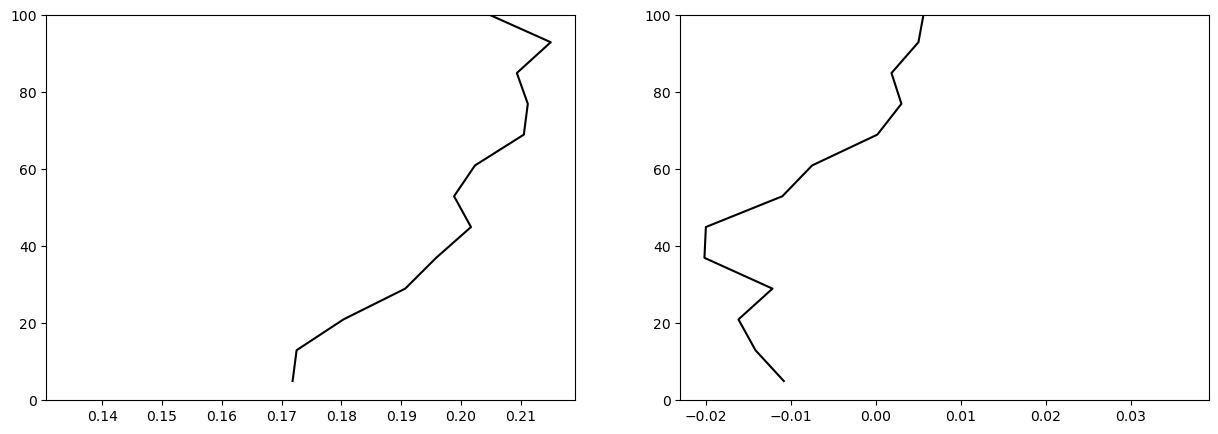

In [18]:
E_depth = 10
alpha = 1/E_depth
V0 = 0.1
x = np.arange(0,300,0.1)

fig, ax = plt.subplots(figsize=(15,5), ncols=2)

ax[0].plot(v_mean, data['dist'],color = 'black' )
ax[1].plot(u_mean, data['dist'],color = 'black' )
ax[0].set_ylim(0,100)
ax[1].set_ylim(0,100)


# ax[1].plot(Ekman_v(x,alpha,V0),x,label = 'Ekman', color = 'orange', linewidth = 1.7)
# ax[0].plot(Ekman_u(x,alpha,V0),x, color = 'orange', linewidth = 1.7)


plt.show()


# Processed

In [26]:
dir = 'processed/'
file = []
for filename in sorted(os.listdir(dir)):
    #print(filename)
    file.append(filename)
file = np.array(file)
file = file[1:]
file

array(['2472.txt', '2482.txt', '2487.txt', '2509.txt'], dtype='<U9')

### Normolised

In [27]:
U = pd.DataFrame([])
V = pd.DataFrame([])
for j in range(file.size):
    data = pd.read_csv(dir+file[j], sep="\t", names=['z','u','v','dist','mod','dir','u_','v_','dir_','refV'],skiprows=1)
    U[file[j]] = data['u_']#/(data['refV'][0])
    print(data['dir_'].head(6), file[j])
    V[file[j]] = data['v_']#/(data['refV'][0])
    #D[file[j]] = data['d']

u_mean = np.array(U.mean(axis = 1))
v_mean = np.array(V.mean(axis = 1))
print(u_mean.size,data['dist'].size)

v = filter_cos(data['dist'],v_mean,30)
u = filter_cos(data['dist'],u_mean,30)
#data

0    354.0
1    350.0
2    350.0
3    351.0
4    354.0
5    356.0
Name: dir_, dtype: float64 2472.txt
0    351.0
1    351.0
2    354.0
3    354.0
4    358.0
5      0.0
Name: dir_, dtype: float64 2482.txt
0      1.0
1      1.0
2      0.0
3      0.0
4    359.0
5    359.0
Name: dir_, dtype: float64 2487.txt
0    4.0
1    6.0
2    6.0
3    4.0
4    3.0
5    1.0
Name: dir_, dtype: float64 2509.txt
37 37


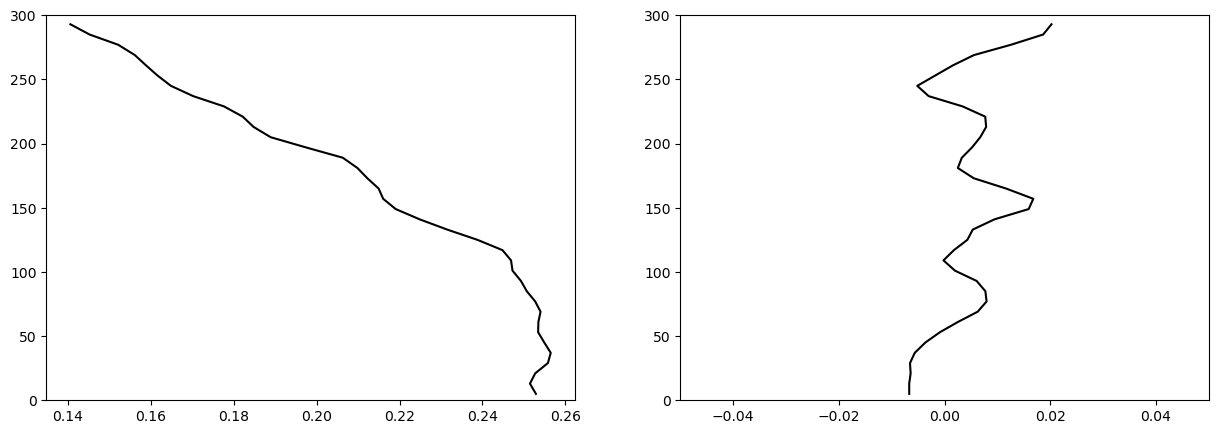

In [28]:
E_depth = 10
alpha = 1/E_depth
V0 = 0.1
x = np.arange(0,300,0.1)

fig, ax = plt.subplots(figsize=(15,5), ncols=2)

ax[0].plot(v, data['dist'],color = 'black' )
ax[1].plot(u, data['dist'],color = 'black' )
ax[0].set_ylim(0,300)
ax[1].set_ylim(0,300)
#ax[0].set_xlim(0,100)
ax[1].set_xlim(-0.05,0.05)
# ax[1].plot(Ekman_v(x,alpha,V0),x,label = 'Ekman', color = 'orange', linewidth = 1.7)
# ax[0].plot(Ekman_u(x,alpha,V0),x, color = 'orange', linewidth = 1.7)


plt.show()

In [29]:
U = pd.DataFrame([])
V = pd.DataFrame([])
for j in range(file.size):
    data = pd.read_csv(dir+file[j], sep="\t", names=['z','u','v','dist','mod','dir','u_','v_','dir_','refV'],skiprows=1)
    U[file[j]] = data['u_']
    #print(data)
    V[file[j]] = data['v_']
    #D[file[j]] = data['d']

u_mean = np.array(U.mean(axis = 1))
v_mean = np.array(V.mean(axis = 1))
print(u_mean.size,data['dist'].size)

v = filter_cos(data['dist'],v_mean,30)
u = filter_cos(data['dist'],u_mean,30)

37 37


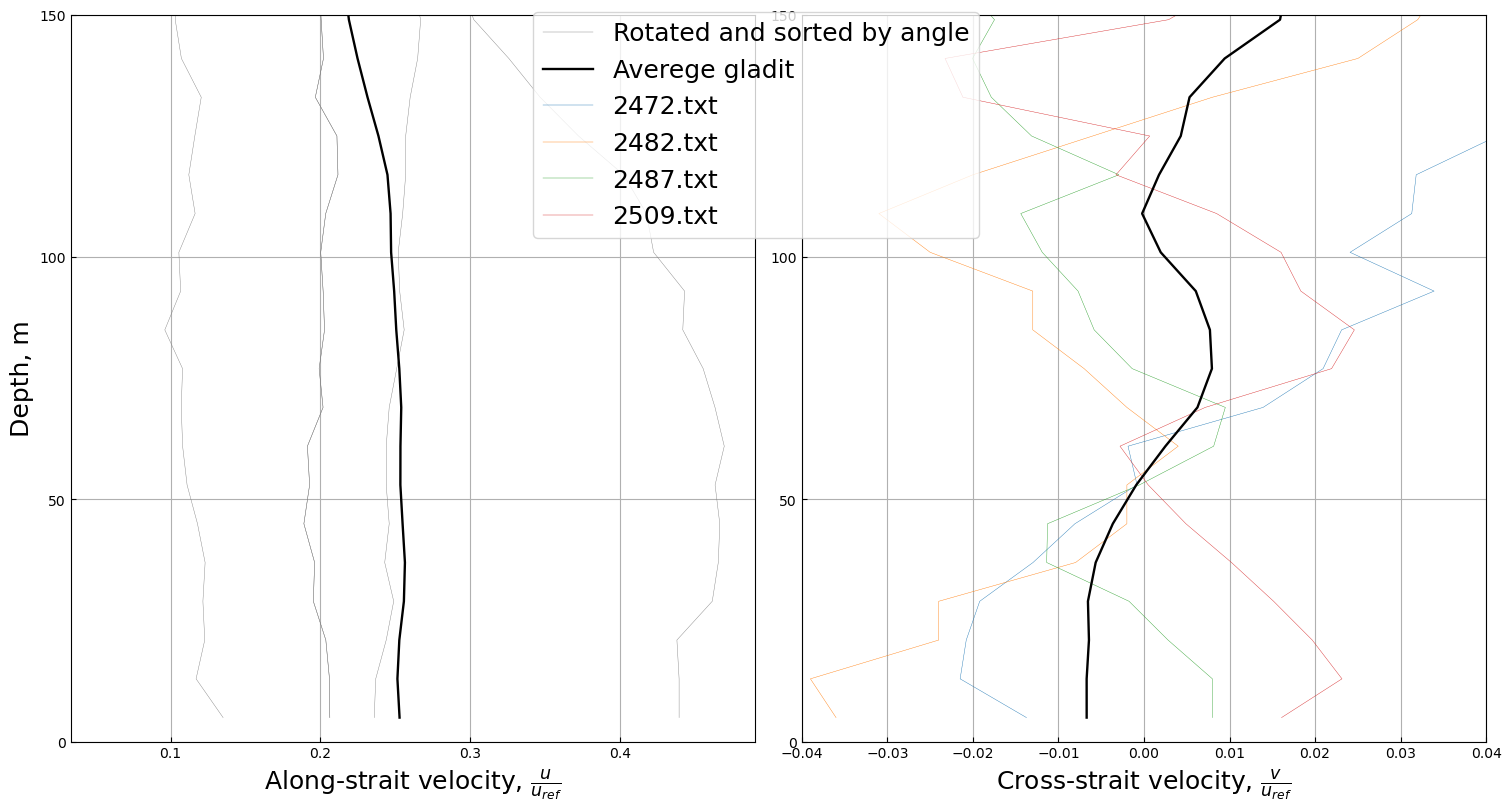

In [30]:
E_depth = 12
alpha = 1/E_depth
V0 = 1
x = np.arange(0,300,0.1)

fig, ax = plt.subplots(figsize=(15,8), ncols=2, layout='constrained')

for i in range(file.size):
    #convert_to_utf8('orkney_300m/' + file[i])
    data = pd.read_csv(dir + file[i], sep="\t", names=['z','u','v','dist','mod','dir','u_','v_','dir_','refV'],skiprows=1)
    #fig, ax = plt.subplots(figsize=(15,5), ncols=2)
    ax[0].plot(data['v_'], data['dist'], color = 'grey', linewidth =0.3) 
    ax[1].plot(data['u_'], data['dist'], linewidth =0.3, label = file[i]) 
    # ax[0].plot(data['v_'], data['dist'], color = 'grey', linewidth =0.3) 
    # ax[1].plot(data['u_'], data['dist'], color = 'grey', linewidth =0.3)  

    #plt.suptitle(file[i])

ax[0].plot(data['v_'], data['dist'], color = 'grey', linewidth =0.3, label = 'Rotated and sorted by angle')


# v = filter_cos(data['dist'],v_mean,30)
# u = filter_cos(data['dist'],u_mean,30)

# ax[0].plot(v_mean, data['dist'], color = 'navy', linewidth = 1.5, label = 'Normolized and avereged \sort by v')
# ax[1].plot(u_mean, data['dist'],  color = 'navy', linewidth =1.5)#, label = 'Normolized and avereged \sort by v')

ax[0].plot(v, data['dist'], color = 'black', linewidth = 1.7, label = 'Averege gladit')
ax[1].plot(u, data['dist'],  color = 'black', linewidth =1.7)#, label = 'Averege')

# ax[1].plot(-Ekman_v(x,alpha,V0),x,label = 'Ekman, layer depth = 12 m', color = 'orange', linewidth = 1.7)
# ax[0].plot(Ekman_u(x,alpha,V0),x, color = 'orange', linewidth = 1.7)


ax[0].set_xlabel(r'Along-strait velocity, $\frac{u}{u_{ref}}$', fontsize = 18)
ax[1].set_xlabel(r'Cross-strait velocity, $\frac{v}{u_{ref}}$', fontsize = 18)
ax[0].set_ylabel(r'Depth, m', fontsize = 18)
#ax[1].set_ylabel(r'Depth, m', fontsize = 12)
ax[0].set_ylim(0,150)
ax[1].set_ylim(0,150)
# ax[0].set_ylim(0,300)
# ax[1].set_ylim(0,300)
#ax[0].set_xlim(0,100)
ax[1].set_xlim(-0.04,0.04)


# ax[0].legend(loc = 'upper right', fontsize = 14)
# ax[1].legend(loc = 'upper right', fontsize = 14)
fig.legend(fontsize = 18, loc = 'upper center')
ax[0].grid()
ax[0].tick_params(axis = 'both', direction = 'in')
ax[1].tick_params(axis = 'both', direction = 'in')
ax[0].locator_params(axis = 'y', nbins = 5)
ax[0].locator_params(axis = 'x', nbins = 6)
ax[1].locator_params(axis = 'y', nbins = 5)
ax[1].grid()
#fig.savefig('v_.png', dpi=150,bbox_inches='tight')

plt.show()

In [31]:
U = pd.DataFrame([])
V = pd.DataFrame([])
for j in range(file.size):
    data = pd.read_csv(dir+file[j], sep="\t", names=['z','u','v','dist','mod','dir','u_','v_','dir_','refV'],skiprows=1)
    U[file[j]] = data['u_']/(data['refV'][0])
    #print(data)
    V[file[j]] = data['v_']/(data['refV'][0])
    #D[file[j]] = data['d']

u_mean = np.array(U.mean(axis = 1))
v_mean = np.array(V.mean(axis = 1))
print(u_mean.size,data['dist'].size)

v = filter_cos(data['dist'],v_mean,30)
u = filter_cos(data['dist'],u_mean,30)

37 37


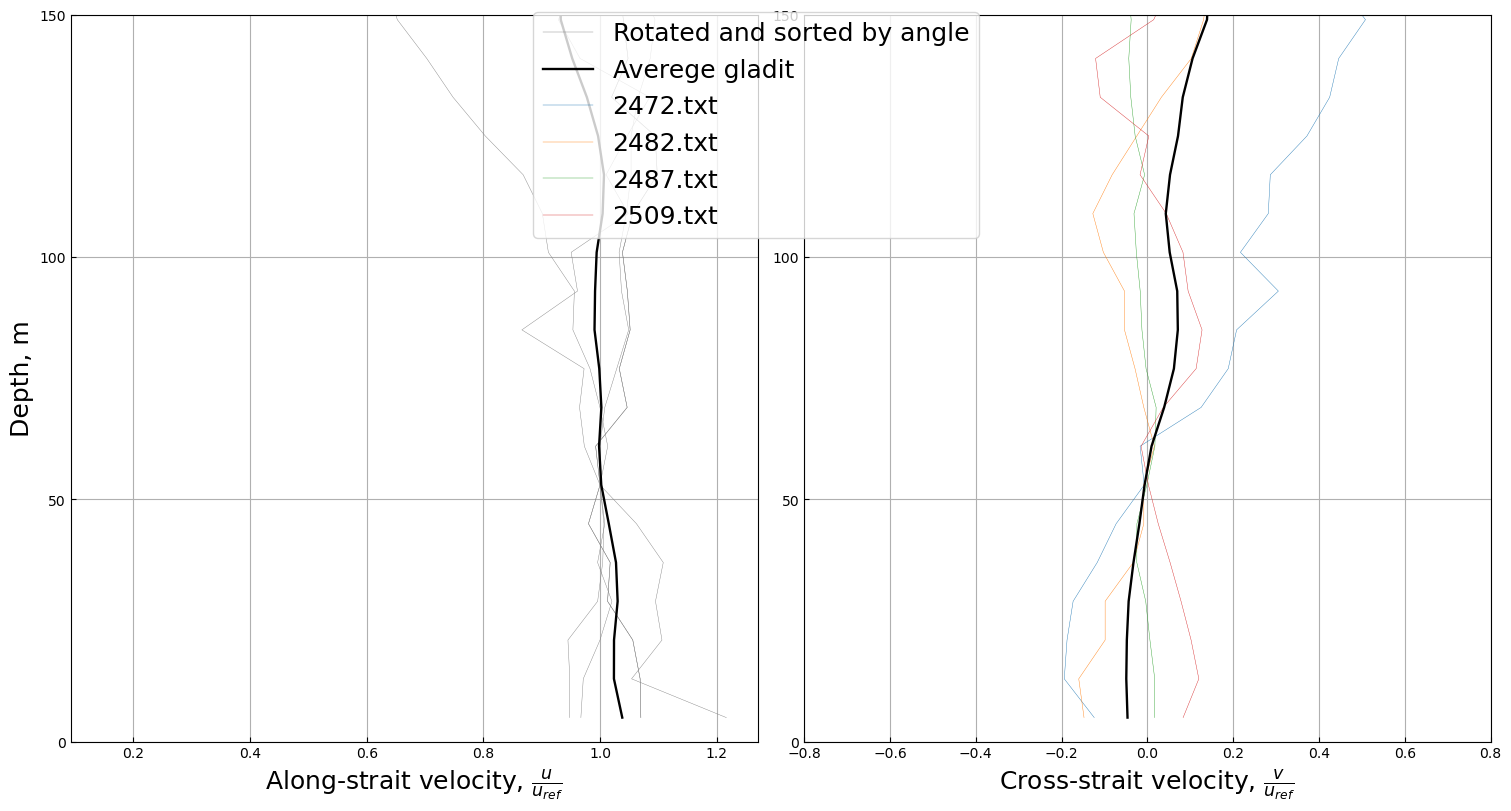

In [32]:
E_depth = 12
alpha = 1/E_depth
V0 = 1
x = np.arange(0,300,0.1)

fig, ax = plt.subplots(figsize=(15,8), ncols=2, layout='constrained')

for i in range(file.size):
    #convert_to_utf8('orkney_300m/' + file[i])
    data = pd.read_csv(dir + file[i], sep="\t", names=['z','u','v','dist','mod','dir','u_','v_','dir_','refV'],skiprows=1)
    #fig, ax = plt.subplots(figsize=(15,5), ncols=2)
    ax[0].plot(data['v_']/(data['refV'][0]), data['dist'], color = 'grey', linewidth =0.3) 
    ax[1].plot(data['u_']/(data['refV'][0]), data['dist'], linewidth =0.3,label = file[i]) 
    # ax[0].plot(data['v_'], data['dist'], color = 'grey', linewidth =0.3) 
    # ax[1].plot(data['u_'], data['dist'], color = 'grey', linewidth =0.3)  

    #plt.suptitle(file[i])

ax[0].plot(data['v_']/(data['refV'][0]), data['dist'], color = 'grey', linewidth =0.3, label = 'Rotated and sorted by angle')


# v = filter_cos(data['dist'],v_mean,30)
# u = filter_cos(data['dist'],u_mean,30)

# ax[0].plot(v_mean, data['dist'], color = 'navy', linewidth = 1.5, label = 'Normolized and avereged \sort by v')
# ax[1].plot(u_mean, data['dist'],  color = 'navy', linewidth =1.5)#, label = 'Normolized and avereged \sort by v')

ax[0].plot(v, data['dist'], color = 'black', linewidth = 1.7, label = 'Averege gladit')
ax[1].plot(u, data['dist'],  color = 'black', linewidth =1.7)#, label = 'Averege')

# ax[1].plot(-Ekman_v(x,alpha,V0),x,label = 'Ekman, layer depth = 12 m', color = 'orange', linewidth = 1.7)
# ax[0].plot(Ekman_u(x,alpha,V0),x, color = 'orange', linewidth = 1.7)


ax[0].set_xlabel(r'Along-strait velocity, $\frac{u}{u_{ref}}$', fontsize = 18)
ax[1].set_xlabel(r'Cross-strait velocity, $\frac{v}{u_{ref}}$', fontsize = 18)
ax[0].set_ylabel(r'Depth, m', fontsize = 18)
#ax[1].set_ylabel(r'Depth, m', fontsize = 12)
ax[0].set_ylim(0,150)
ax[1].set_ylim(0,150)
# ax[0].set_ylim(0,300)
# ax[1].set_ylim(0,300)
#ax[0].set_xlim(0,100)
ax[1].set_xlim(-0.8,0.8)


# ax[0].legend(loc = 'upper right', fontsize = 14)
# ax[1].legend(loc = 'upper right', fontsize = 14)
fig.legend(fontsize = 18, loc = 'upper center')
ax[0].grid()
ax[0].tick_params(axis = 'both', direction = 'in')
ax[1].tick_params(axis = 'both', direction = 'in')
ax[0].locator_params(axis = 'y', nbins = 5)
ax[0].locator_params(axis = 'x', nbins = 6)
ax[1].locator_params(axis = 'y', nbins = 5)
ax[1].grid()
#fig.savefig('v_.png', dpi=150,bbox_inches='tight')

plt.show()

### Normolised and avereged

In [420]:
from matplotlib import markers
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.colors import Normalize

In [421]:
data['dist'][7]
u = np.array(u)

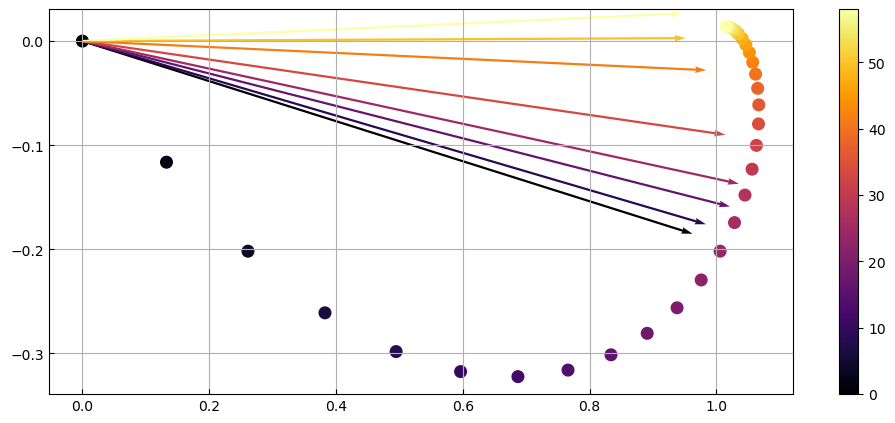

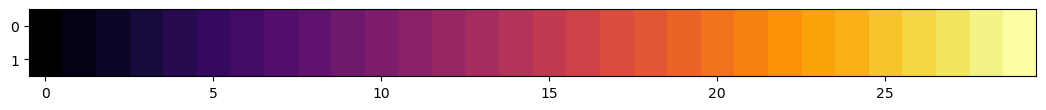

In [428]:
x = np.arange(0,60,2)
fig, ax = plt.subplots(figsize=(12,5))
ind = 8
z = data['dist'][:ind]

# for i in range(u[:ind].size):
#     ax.annotate(round(data['dist'][i]),(v[i]-0.01,u[i]+0.01),fontsize=10, color = 'k')
# for j in range(u[:ind].size):
#     arr = mpatches.FancyArrowPatch((0, 0), (v[j],u[j]),\
#         arrowstyle='->,head_width=.30', mutation_scale=30, color = cm.PuOr(z/(max(z))))
#     ax.add_patch(arr)
cmap = plt.colormaps['inferno']

colors = cmap(np.linspace(0, 1, ind))

norm = Normalize()
norm.autoscale(colors)

cax = ax.scatter(Ekman_u(x,alpha,V0), -Ekman_v(x,alpha,V0), s = 70, c = cm.inferno(x/(max(x))), marker=markers.MarkerStyle('o', fillstyle = 'full'), label = 'Ekman spiral')

for i, color in enumerate(colors):
    ax.quiver(0,0,v[i],u[i], angles='xy', scale_units='xy',scale=1., width = 0.003, color = color)

b = np.arctan2(v[0],np.abs(u[0]))
b = round(np.rad2deg(b))
b = 90-b

ax.grid()
ax.tick_params(axis = 'both', direction = 'in')
ax.locator_params(axis = 'y', nbins = 6)
ax.locator_params(axis = 'x', nbins = 6)

#ax.set_ylim(-0.08,0.35)
#ax.set_xlim(-0.3, 0.35)

#x.scatter(v[:ind],np.abs(u[:ind]), c = colors, s = 75, marker=markers.MarkerStyle('o', fillstyle = 'full'))
fig2, ax3 = plt.subplots(figsize=(13,5))
map1 = ax3.imshow(np.stack([x, x]),cmap='inferno')
fig.colorbar(map1, ax=ax)

plt.show()

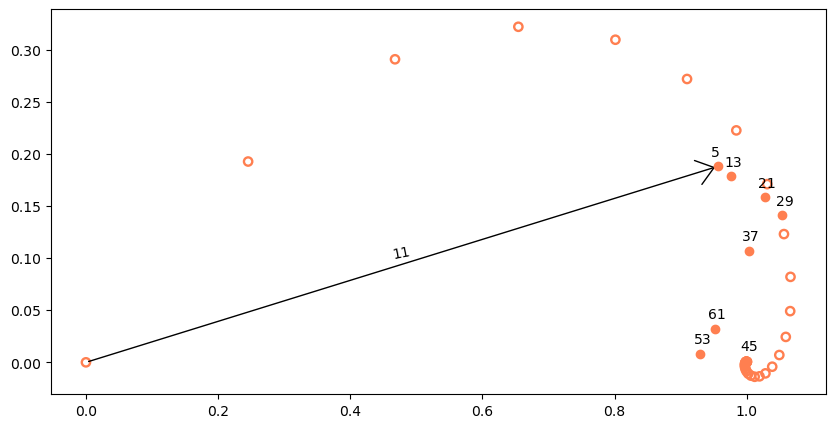

In [372]:
x = np.arange(0,100,3)
fig, ax = plt.subplots(figsize=(10,5))
ind = 8
ax.scatter(Ekman_u(x,alpha,V0),Ekman_v(x,alpha,V0),label = 'Ekman', color = 'coral', linewidth = 1.7,\
     marker=markers.MarkerStyle('o', fillstyle = 'none'))
for i in range(u_mean[:ind].size):
    ax.annotate(round(data['dist'][i]),(v_mean[i]-0.01,np.abs(u_mean)[i]+0.01),fontsize=10, color = 'k')

arr = mpatches.FancyArrowPatch((0, 0), (v_mean[0],np.abs(u_mean[0])),
                               arrowstyle='->,head_width=.30', mutation_scale=30)

b = np.arctan2(v_mean[0],np.abs(u_mean[0]))
b = round(np.rad2deg(b))
b = 90-b


ax.annotate(b, (.5, .5), xycoords=arr, ha='center', va='bottom',rotation=b, size=10)


ax.add_patch(arr)

ax.scatter(v_mean[:ind],np.abs(u_mean[:ind]), color = 'coral', marker=markers.MarkerStyle('o', fillstyle = 'full'))
plt.show()